## Nearest-Neighbor Density Estimation

Gordon Richards (2016, 2018)

Another very simple way to estimate the density of an $N$-dimensional distribution is to look to the nearest object (or the $K$ nearest objects) and compute their distances, $d_K$.  This is the [$K$-Nearest Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm.  We'll see later that this is also a good method to use for classification.

In this prescription, the density at a given point, $x$ is estimated as

$$\hat{f}_K(x) = \frac{K}{V_D(d_K)}$$

where $V_D(d)$ is given generically by $\frac{2d^D\pi^{D/2}}{D\Gamma(D/2)}$ where $\Gamma$ is the complete gamma function (Equation 3.58) and this formula reduces to the usual equations for area and volume in 2 and 3 dimensions, respectively.

We can simplify this to 
$$\hat{f}_K(x) = \frac{C}{d_K^D}$$
since the constant, $C$ can be evaluated at the end.

N.B. this estimator is **biased**.  What does that mean?

### Aside on Bias (Precision and Accuracy too)
In this context, it means that our estimator is known to yield a value that is offset from the true value.  What is labeled as "accuracy" here is more correctly called "bias".  This isn't the usual way that you might think of the word, but if you think about it, the meanings are actually consistent.

![https://en.wikipedia.org/wiki/Accuracy_and_precision](../figures/520px-Accuracy_and_precision.svg.png)

This figures illustrates the difference between bias and precision.  Panel **a** has high **bias** (which is bad) and low **precision** (also bad); it is not very **accurate**.  Panel **b** has low bias and low precision.  Panel **c** has high bias and high precision.  Panel **d** has low bias (which is good) and high precision (which is good); it is very accurate.

![https://www.researchgate.net/figure/Illustration-of-the-concepts-of-accuracy-precision-and-bias-a-High-bias-low-precision_fig1_283653212](../figures/Illustration-of-the-concepts-of-accuracy-precision-and-bias-a-High-bias-low-precision.png)

Back to our (nearest-neighbor) density estimator:

$$\hat{f}_K(x) = \frac{C}{d_K^D}.$$

Because this is biased, ideally we don't actually want the *nearest* neighbor, but rather we want something like the *5th* nearest neighbor (or larger).  For example see this figure from the wikipedia link above:

![https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/200px-KnnClassification.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/200px-KnnClassification.svg.png)


In fact, the error in the estimator can be reduced by considering *all* $K$ nearest neighbors:
$$\hat{f}_K(x) = \frac{C}{\sum_{i=1}^K d_i^D}$$

See the [Scikit-Learn `neighbors` documentation](http://scikit-learn.org/stable/modules/neighbors.html) for more information.

Ivezic, Figure 6.5 compares a Nearest Neighbor ($k=10$) with a KDE algorithm.  See what happens as you increase the number of neighbors used.

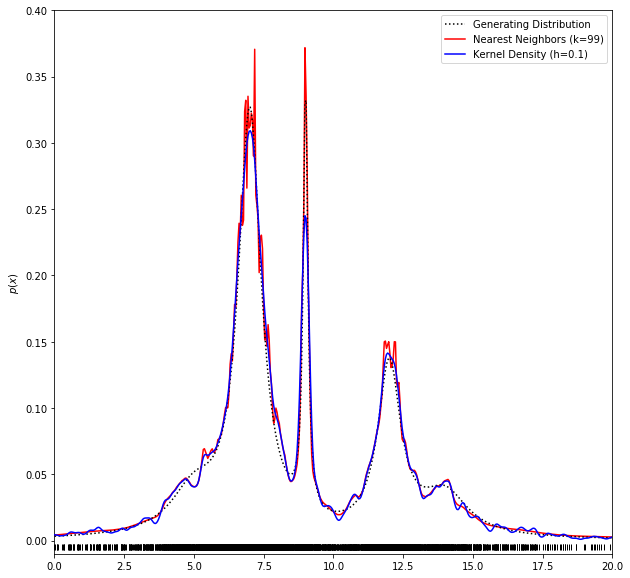

In [6]:
# Based on Ivezic, Figure 6.5
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from astroML.density_estimation import KNeighborsDensity
from astroML.plotting import hist

from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x) for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N)) for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))
N = 5000
k = 99

xN = x[:N]
t = np.linspace(-10, 30, 1000)

# Compute density with KDE
kde = KernelDensity(0.1, kernel='gaussian')
kde.fit(xN[:, None])
dens_kde = np.exp(kde.score_samples(t[:, None]))

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN[:, None])
dens_nbrs = nbrs.eval(t[:, None]) / N

# plot the results
plt.plot(t, true_pdf(t), ':', color='black', zorder=3, label="Generating Distribution")
plt.plot(xN, -0.005 * np.ones(len(xN)), '|k')
plt.plot(t, dens_nbrs, '-', lw=1.5, color='red', zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.plot(t, dens_kde, '-', color='blue', zorder=3, label="Kernel Density (h=0.1)")

# label the plot
#plt.text(0.02, 0.95, "%i points" % N, ha='left', va='top', transform=ax.transAxes)
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
plt.xlim(0, 20)
plt.ylim(-0.01, 0.4001)

plt.show()

Nearest-neighbors are both pretty simple and pretty powerful.  But you can imagine that they could also be really slow if you have either a lot of points or want to consider a lot of neighbors as  you have to compute all of the pairwise distances!  You can certainly do this "brute force" computation, but the use of **trees** speeds things up considerably.

We haven't talked about **order notation** yet, but now is a good time to introduce it.  If we say that something "goes as $\mathscr{O}(N)$", that means that $N$ operations are needed.  If is it $\mathscr{O}(N^2)$, then $N\times N$ operations are needed.

If we have $N$ samples with $D$ features, then brute force nearest neighbor goes as $\mathscr{O}(DN)$.  That can be a very large number of operations and make our code run slow.  So, can we do it faster?

### Trees

It seems like you would be stuck computing all of the distances, but consider this:

> if point A is very distant from point B, and point B is very close to point C, then we know that points A and C are very distant.

So, we just have to compute the A-B and B-C distances; we don't actually need to compute A-C.

We can take advantage of this using **trees**.  In 2-D we use a [**quad-tree**](https://en.wikipedia.org/wiki/Quadtree), which is illustrated in Ivezic, Figure 2.3 below.

![Ivezic, Figure 2.3](http://www.astroml.org/_images/fig_quadtree_example_1.png)

What is happening is that the data space gets broken down into smaller and smaller bins.  Then instead of computing the distances between each of the *objects*, we compute the distances between each of the *bins*.  We only compute the distances between objects if the bin distances are small enough to be considered further.  This process can speed up nearest neighbor finding considerably.  

For a quad-tree we are specifically dividing the 2-D space into 4 equal "nodes" (children) until each box is either empty or has no more than some number of points.  The terminal nodes are called "leaves", thus the name "tree".  In 3-D we instead have **oct-trees**.  

We can generalize this to $k$ dimensions but the scaling as $2^D$ quickly gets out of control and is called the [**curse of dimensionality**](https://en.wikipedia.org/wiki/Curse_of_dimensionality) (more on that next week).   So for so-called [**$k$D-tree**](https://en.wikipedia.org/wiki/K-d_tree) we instead use *binary* trees where each node has 2 children instead of 4.   $k$D trees further split the *data* into two rather than the box into two.  A $k$D-tree is illustrated in Ivezic, Figure 2.4 below.

![Ivezic, Figure 2.4](http://www.astroml.org/_images/fig_kdtree_example_1.png)

For $k$D trees no $D$-dimensional distances need to be computed, so once the tree is constructed, the nearest neighbor determination is only $\mathscr{O}(D \log N)$.

In Scikit-Learn $k$D Trees are implemented in [http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)

As long as $D$ isn't *too* large ($\lesssim 20$), this works well, but $k$D trees also suffer from the curse of dimensionality for large $D$ and go as $\mathscr{O}(DN)$. In that case, we can use [**ball-trees**](https://en.wikipedia.org/wiki/Ball_tree) instead.  

Instead of using Cartesian axes, ball-trees split the data into nesting hyper spheres.  This makes it more "expensive" to build the tree, but it makes finding the nearest neighbors faster $\mathscr{O}(D \log N)$.

For more information on ball-trees in Scikit-Learn, see [http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

An example from Ivezic is shown below
![Ivezic, Figure 2.5](http://www.astroml.org/_images/fig_balltree_example_1.png)

### Creating an evaluation grid

Now let's look at nearest neighbors in 2-D.  Note that for 1-D we had to define the "grid" over which we evaluated the pdf and we did something like 

```t = np.linspace(-10, 30, 1000)```

We need to do the same in 2-D.  That seems easy enough, right?  If $x$ runs from 0 to 10 and $y$ runs from 0 to 10 and we want to evaluate in steps of 1 in each direction, then we just need to build a grid that includes the points, $(0,0), (1,0), (0,1) \dots (10,9), (9,10), (10,10)$. 

As far as I know there is no simple tool that does this.  But we can use [`np.meshgrid()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) to help us as follows

In [8]:
x = np.linspace(0,10,11)
y = np.linspace(0,10,11)

print (x,y)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [9]:
xv,yv = np.meshgrid(x,y)
print(xv)
print(yv)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [10. 10. 10

In [11]:
print(xv.ravel())
print(yv.ravel())
# Equivalent to flatten(), except for making a copy (or not) of the array

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.
  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.
  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.
 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.
  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.
  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [12]:
xystack = np.vstack([xv.ravel(),yv.ravel()])
print(xystack)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.
   7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.
   3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.
  10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.
   6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.
   2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.
   9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
   4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.
   6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.
   9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]


In [14]:
Xgrid = xystack.T
print(Xgrid)

[[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [10.  0.]
 [ 0.  1.]
 [ 1.  1.]
 [ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8.  1.]
 [ 9.  1.]
 [10.  1.]
 [ 0.  2.]
 [ 1.  2.]
 [ 2.  2.]
 [ 3.  2.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  2.]
 [ 7.  2.]
 [ 8.  2.]
 [ 9.  2.]
 [10.  2.]
 [ 0.  3.]
 [ 1.  3.]
 [ 2.  3.]
 [ 3.  3.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  3.]
 [ 7.  3.]
 [ 8.  3.]
 [ 9.  3.]
 [10.  3.]
 [ 0.  4.]
 [ 1.  4.]
 [ 2.  4.]
 [ 3.  4.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  4.]
 [ 7.  4.]
 [ 8.  4.]
 [ 9.  4.]
 [10.  4.]
 [ 0.  5.]
 [ 1.  5.]
 [ 2.  5.]
 [ 3.  5.]
 [ 4.  5.]
 [ 5.  5.]
 [ 6.  5.]
 [ 7.  5.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  5.]
 [ 0.  6.]
 [ 1.  6.]
 [ 2.  6.]
 [ 3.  6.]
 [ 4.  6.]
 [ 5.  6.]
 [ 6.  6.]
 [ 7.  6.]
 [ 8.  6.]
 [ 9.  6.]
 [10.  6.]
 [ 0.  7.]
 [ 1.  7.]
 [ 2.  7.]
 [ 3.  7.]
 [ 4.  7.]
 [ 5.  7.]
 [ 6.  7.]
 [ 7.  7.]
 [ 8.  7.]
 [ 9.  7.]
 [10.  7.]
 [ 0.  8.]
 [ 1.  8.]
 [ 2.  8.]

In [16]:
grid = [[x,y] for x in range(11) for y in range(11)]
print(grid)

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 10], [8, 0], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9], [8, 10], [9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [9, 10], [10, 0], [10, 1], [10, 2], [10, 3], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 9], [10, 10]]


Note that, while I said that there is no built in function for this, there are any number of ways to accomplish this!  For example, using `map`, `np.mgrid()`, transposes, etc.

The code below accomplishes it in just one line, but I thought that it would make more sense if we broke it down like we did above.

/usr/local/lib/python3.7/site-packages/astroML/density_estimation/density_estimation.py:74: UserWarning: The KDE class is deprecated as of version 0.2 and will be removed in version 0.3. Upgrade to scikit-learn version >0.14 and use sklearn.neighbors.KernelDensity instead.
  warnings.warn("The KDE class is deprecated as of version 0.2 and will "


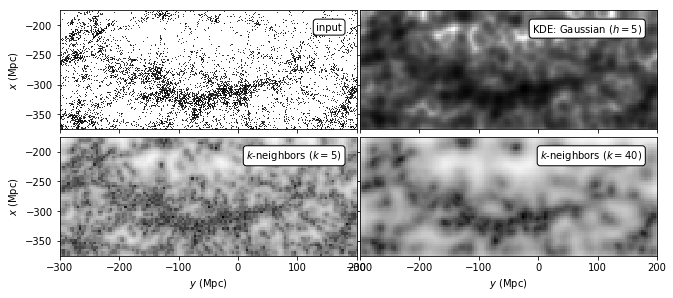

In [19]:
# Comparison of KDE and K-Nearest Neighbors "smoothing"
# Based on Ivezic, Figure 6.4
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from scipy.spatial import cKDTree

from astroML.datasets import fetch_great_wall
#from astroML.density_estimation import KDE, KNeighborsDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx), np.linspace(ymin, ymax, Ny)))).T

#print Xgrid

#kde = KDE(metric='gaussian', h=5)
kde = KernelDensity(kernel='gaussian', bandwidth=5)
dens_KDE = np.exp(kde.fit(X).score_samples(Xgrid).reshape((Ny, Nx)))

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(np.exp(dens_KDE.T), origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "KDE: Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "$k$-neighbors $(k=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "$k$-neighbors $(k=40)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

What the "right" answer is depends on what you want to do with the data.  

Next time we'll talk about Gaussian Mixture Models and K-Means Clustering.

To get started for next time, let's learn how to read in a data sample that we are going to use.

http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

In [18]:
#eruptions: Eruption time in mins
#waiting: Waiting time to next eruption
import pandas as pd
df = pd.read_csv('../data/faithful.dat', delim_whitespace=True)
df.head()

,N,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


Make two "fancy" histograms illustrating the distribution of `x=df['eruptions']` and `y=df['waiting']` times.  Use `bins="freedman"` and `histtype="step"`.

In [ ]:
from astroML.plotting import hist as ____

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
fancyhist(___,___,___)
plt.xlabel('Eruptions')
plt.ylabel('N')

ax = fig.add_subplot(122)
fancyhist(___,___,___)
plt.xlabel('Waiting')
plt.ylabel('N')

Now make a 2-D scatter plot with `plt.scatter()`.

In [ ]:
plt.____(____,____)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')